# Dataset Files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# #Uncomment to unzip in colab
!cp "/content/drive/My Drive/dress_dataset_v2.zip" "dress_dataset.zip"
!unzip -q dress_dataset.zip
%rm -r dress_dataset_v2/kimono
# !rm dress_dataset.zip

warning [dress_dataset.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [dress_dataset.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #97836).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


# Imports

In [1]:
#import libraries
import os
import cv2
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Load Dataset

In [0]:
#Function to load the data and bounding boxes
def load_dataset(path, classes,count=5000) :
    images = []
    labels = []
    bboxes = []
    label_enc = 0;
    for cls in classes :
        subclasses = os.listdir(path + cls + "/")
        flag = 0
        for subclass in subclasses :
            if not os.path.isdir(path + cls + "/" + subclass) :
                f = open(path + cls + "/" + "bboxes.txt", "r")
                
                for line in f :
                    if(flag == count):
                        break
                    coordinates = []
                    c = line[-16:]
                    try :
                        #Load the Images
                        img_path = path + cls + "/" + line[:-16]
                        img_path = img_path.strip()
                        img = cv2.imread(img_path)
                        
                        y_ = img.shape[0]
                        x_ = img.shape[1]
                        
                        x_scale = 224/x_
                        y_scale = 224/y_
                        
                        img = cv2.resize(img, (224, 224))
                        images.append(img)
                        flag+=1
                        labels.append(label_enc)

                        #Load bounding boxes
                        for i in range(4) :
                            for coordinate in c[i*4:i*4+4].split() :
                                if coordinate.isdigit() :
                                    coordinates.append(int(coordinate))
                        coordinates[0] = round(coordinates[0]*x_scale)
                        coordinates[1] = round(coordinates[1]*y_scale)
                        coordinates[2] = round(coordinates[2]*x_scale)
                        coordinates[3] = round(coordinates[3]*y_scale)
                        bboxes.append(coordinates)
                    except Exception as e :
                        pass

                f.close()
        label_enc += 1
    return np.array(images), np.array(bboxes), np.array(labels)

In [0]:
#Load the dataset
DATADIR = "dress_dataset_v2/"
classes = os.listdir("dress_dataset_v2")
print(classes)
img_data, bboxes, labels = load_dataset(DATADIR, classes,count=6000)
print("------------------------Loaded the Images--------------------------")
print("image_datset shape : ", img_data.shape)
print("bboxes shape : ", bboxes.shape)
print("labels shape : ", labels.shape)

['Jacket', 'Skirt', 'T-Shirt', 'Shorts', 'Top']
------------------------Loaded the Images--------------------------
image_datset shape :  (30000, 224, 224, 3)
bboxes shape :  (30000, 4)
labels shape :  (30000,)


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

class label :  0


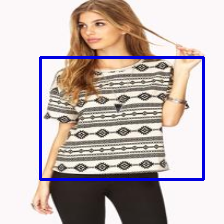

In [0]:
#Display an image and its bounding box
from google.colab.patches import cv2_imshow
index=3
test_img = img_data[index]
test_bbox = bboxes[index]
print("class label : ", labels[index])
test_img = cv2.rectangle(test_img, (test_bbox[0], test_bbox[1]), (test_bbox[2], test_bbox[3]), (225, 0, 0), 2)
cv2_imshow(test_img)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.33, random_state=42)
del img_data
del labels
num_of_classes = 5
y_train = keras.utils.to_categorical(y_train, num_of_classes)
y_test = keras.utils.to_categorical(y_test, num_of_classes)

# Dress Classification ResNet Model

In [0]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

class DressClassification:

    def __init__(self,x_train,x_test,y_train,y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def define_base_model(self,HEIGHT,WIDTH):
        self.base_model = ResNet50(
            weights='imagenet', 
            include_top=False, 
            input_shape=(HEIGHT, WIDTH, 3)
        )
        return self.base_model

    def build_finetune_model(self, dropout, fc_layers, num_classes):
        for layer in self.base_model.layers:
            layer.trainable = False

        x = self.base_model.output
        x = Flatten()(x)
        for fc in fc_layers:
            # New FC layer, random init
            x = Dense(fc, activation='relu')(x) 
            x = Dropout(dropout)(x)

        # New softmax layer
        predictions = Dense(num_classes, activation='softmax')(x) 
        
        self.finetune_model = Model(inputs=self.base_model.input, outputs=predictions)

        return self.finetune_model

    def fit(self,epoch=10,batch_size=8,dropout=0.5,fc_layers=[1024, 1024],lr=0.00001):
        
        self.define_base_model(224,224)

        self.build_finetune_model( 
            dropout=dropout, 
            fc_layers=fc_layers, 
            num_classes=5
        )

        adam = Adam(lr=lr)
        self.finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

        filepath="./" + "ResNet50" + "_model_weights.h5"
        checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
        callbacks_list = [checkpoint]

        self.history = self.finetune_model.fit(
            self.x_train, self.y_train,
            epochs=epoch,
            workers=8, 
            batch_size=batch_size, 
            validation_data=(self.x_test,self.y_test), 
            callbacks=callbacks_list
        )
        return self.history

# First Model (With all categories)

In [0]:
model = DressClassification(x_train,x_test,y_train,y_test)
model.fit(
    epoch=10,
    batch_size=8,
    dropout=0.5,
    fc_layers=[1024,1024],
    lr=0.00001
)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Train on 20100 samples, validate on 9900 samples
Epoch 1/10
20100/20100 [==============================] - 333s 17ms/step - loss: 1.4154 - accuracy: 0.4888 - val_loss: 0.9496 - val_accuracy: 0.6193

Epoch 00001: saving model to ./ResNet50_model_weights.h5
Epoch 2/10
20100/20100 [==============================] - 332s 16ms/step - loss: 0.9849 - accuracy: 0.6191 - val_loss: 0.9158 - val_accuracy: 0.6414

Epoch 00002: saving model to ./ResNet50_model_weights.h5
Epoch 3/10
20100/20100 [==============================] - 331s 16ms/step - loss: 0.8649 - accuracy: 0.6682 - val_loss: 0.9022 - val_accuracy: 0.6568

Epoch 00003: saving model to ./ResNet50_model_weights.h5
Epoch 4/10
20100/20100 [==============================] - 331s 16ms/step - loss: 0.7581 - accuracy: 0.7152 - val_loss: 0.8760 - val_accuracy: 0.6743

Epoch 00004: saving model to ./ResNet50_model_weights.h5
Epoch 5/10
20100/20100 [==============================] - 333s 17ms/step - loss: 0.6641 - accuracy: 0.7497 - val_loss: 0.90

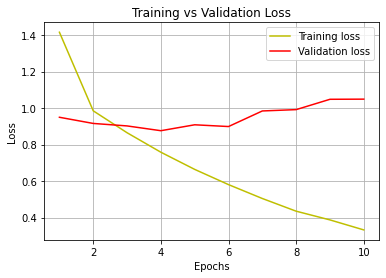

In [0]:
train_loss = [1.4154, 0.9849, 0.8649 , 0.7581, 0.6641, 0.5807, 0.5046, 0.4351, 0.3873, 0.3325] 
val_loss = [0.9496, 0.9158, 0.9022, 0.8760, 0.9084, 0.8988, 0.9842, 0.9915, 1.0481, 1.0489]
epochs = range(1, 11)
# plt.figure(figsize=(20,10))
plt.plot(epochs, train_loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
# plt.savefig('loss comparision')
plt.show()

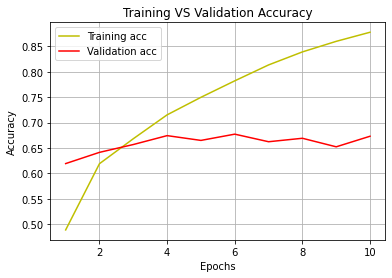

In [0]:
train_acc = [0.4888, 0.6191, 0.6682, 0.7152, 0.7497, 0.7821, 0.8134, 0.8390, 0.8598, 0.8777]
val_acc = [0.6193, 0.6414, 0.6568, 0.6743, 0.6649, 0.6772, 0.6623, 0.6691, 0.6523, 0.6731]
# plt.figure(figsize=(20,10))
plt.plot(epochs, train_acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training VS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
# plt.savefig('accuracy comparision')
plt.show()

# Second Model (After removing category-Shorts)

In [0]:
classes.pop(3)
print(classes)
del img_data[18000:24000]
del labels[18000:24000]
x_train, x_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.33, random_state=42)

['Jacket', 'Skirt', 'T-Shirt', 'Top']


In [0]:
model = DressClassification(x_train,x_test,y_train,y_test)
model.fit(
    epoch=10,
    batch_size=8,
    dropout=0.5,
    fc_layers=[1024,1024],
    lr=0.00001
)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
Train on 16080 samples, validate on 7920 samples
Epoch 1/10
16080/16080 [==============================] - 274s 17ms/step - loss: 1.2735 - accuracy: 0.5374 - val_loss: 0.7688 - val_accuracy: 0.6808

Epoch 00001: saving model to ./ResNet50_model_weights.h5
Epoch 2/10
16080/16080 [==============================] - 268s 17ms/step - loss: 0.8481 - accuracy: 0.6606 - val_loss: 0.7515 - val_accuracy: 0.6943

Epoch 00002: saving model to ./ResNet50_model_weights.h5
Epoch 3/10
16080/16080 [==============================] - 267s 17ms/step - loss: 0.7294 - accuracy: 0.7092 - val_loss: 0.7514 - val_accuracy: 0.7081

Epoch 00003: saving model to ./ResNet50_model_weights.h5
Epoch 4/10
16080/16080 [==============================] - 266s 17ms/step - loss: 0.6397 - accuracy: 0.7496 - val_loss: 0.7756 - val_accuracy: 0.7181

Epoch 00004: saving model to ./ResNet50_model_weights.h5
Epoch 5/10
16080/16080 [==============================] - 

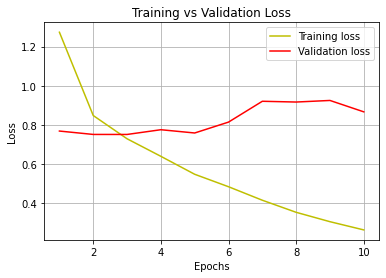

In [7]:
train_loss = [1.2735, 0.8481, 0.7294, 0.6397, 0.5480, 0.4844, 0.4154, 0.3537, 0.3058, 0.2638]
val_loss = [0.7688, 0.7515, 0.7514, 0.7756, 0.7589, 0.8145, 0.9209, 0.9170, 0.9251, 0.8669]
epochs = range(1, 11)
# plt.figure(figsize=(20,10))
plt.plot(epochs, train_loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
# plt.savefig('model2 loss comparision')
plt.show()

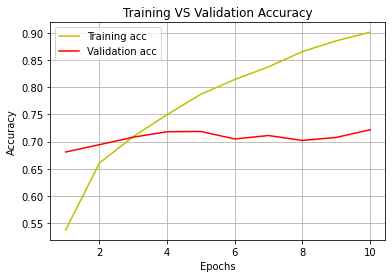

In [6]:
train_acc = [0.5374, 0.6606, 0.7092, 0.7496, 0.7872, 0.8142, 0.8376, 0.8656, 0.8854, 0.9012]
val_acc = [0.6808, 0.6943, 0.7081, 0.7181, 0.7186, 0.7048, 0.7111, 0.7021, 0.7076, 0.7217]
# plt.figure(figsize=(20,10))
plt.plot(epochs, train_acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training VS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
# plt.savefig('model2 accuracy comparision')
plt.show()

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5753882276973018074
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4649793969125348
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12920263269468788088
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648777152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3265272583654409307
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]
